# Computing a SVM Model for Accurate Fake News Detection

### STEP 1: Importing the libraries

In [252]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import warnings

sb.set_theme()
warnings.filterwarnings('ignore')

### STEP 2: Reading the Data

In [231]:
df=pd.read_csv('WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [233]:
# Drop the 'Unnamed' column
df = df.drop(df.columns[0], axis=1)
df.head()


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [234]:
# to confirm that the unamed colum is removed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [235]:
df.isnull().sum()
# Print rows with missing or placeholder titles
# Save rows with missing or empty titles
missing_titles = df[df['title'].isnull() | (df['title'] == "")]
print(f"Rows with missing titles before filling:\n{missing_titles}")


Rows with missing titles before filling:
      title                                               text  label
1       NaN     Did they post their votes for Hillary already?      1
43      NaN  True. Hillary needs a distraction and what bet...      1
162     NaN  All eyes on Electoral delegates. The People kn...      1
185     NaN                                               Cool      1
269     NaN  A leading US senator: US Supporting War in Syr...      1
...     ...                                                ...    ...
71484   NaN  Another Arab supremacist masturbation fantasy....      1
71521   NaN  I'm sure they drastically changed accounting m...      1
71540   NaN  It's easy to imagine Obama or Kerry pissing hi...      1
71570   NaN  Ever since the powers to be assassinated JFK A...      1
71734   NaN             Hmm, free college, now that's an idea.      1

[558 rows x 3 columns]


In [236]:
# imputation not suitable to highly variable context-dependant text data

# we drop rows with missing text as this is the main subject of the anlsyis & less than 10% of the df is missing
df = df.dropna(subset=['text'])

# filling the missing values in the title column with "no title" 
df['title'] = df['title'].fillna("no title")
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [237]:
# Verify the previously missing rows have been updated
updated_rows = df.loc[missing_titles.index]
print("Updated rows:")
print(updated_rows[updated_rows['title'] == "no title"])

Updated rows:
          title                                               text  label
1      no title     Did they post their votes for Hillary already?      1
43     no title  True. Hillary needs a distraction and what bet...      1
162    no title  All eyes on Electoral delegates. The People kn...      1
185    no title                                               Cool      1
269    no title  A leading US senator: US Supporting War in Syr...      1
...         ...                                                ...    ...
71484  no title  Another Arab supremacist masturbation fantasy....      1
71521  no title  I'm sure they drastically changed accounting m...      1
71540  no title  It's easy to imagine Obama or Kerry pissing hi...      1
71570  no title  Ever since the powers to be assassinated JFK A...      1
71734  no title             Hmm, free college, now that's an idea.      1

[558 rows x 3 columns]


Must check the class imbalance; if not significant (over 10-15%), we can continue with the model. 

This is also ecause our datstset is large with over 70k samples.

In [238]:
news_counts = df['label'].value_counts()

# Display the counts
print("Count of True and Fake News:")
print(news_counts)

Count of True and Fake News:
1    37067
0    35028
Name: label, dtype: int64


### STEP 3: Preprocessing the data

Chosen preprocessing method:
- Remove stopwords (words which don't add significance & create uncessary overhead)
- Text cleaning (remove punctuation, numbers, special characters)
- Case-folding to lowercase
- Lemmatize

In [239]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [240]:
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/diya_paul/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diya_paul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/diya_paul/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [244]:
negation_words= {'no', 'not', 'neither', 'none', 'nobody', 'nor', 'nothing', 'nowhere', 'never'}
stop_words= stop_words - negation_words

In [245]:
# Text preprocessing (optional: remove stopwords)
df['clean_text'] = df['text'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True)

df['clean_text'] =df['clean_text'].apply(lambda x: x.split()) # tokenize the text

print(df['clean_text'].head())  # Inspect the first few rows
print(df['clean_text'].dtype)  # Check the column's data type

df['clean_text'] = df['clean_text'].apply(lambda x:[word for word in x if word not in stop_words])
print(df['clean_text'].head())  # Inspect the first few rows
print(df['clean_text'].dtype)  # Check the column's data type

df['clean_text'] = df['clean_text'].apply(lambda x: [lemmatizer.lemmatize(word, pos='v') for word in x])

print(df['clean_text'].head())  # Inspect the first few rows
print(df['clean_text'].dtype)  # Check the column's data type

df['clean_text'] = df['clean_text'].apply(lambda x:' '.join(x))

print(df['clean_text'].head())  # Inspect the first few rows
print(df['clean_text'].dtype)  # Check the column's data type

df[['text', 'clean_text']].head()

0    [no, comment, is, expected, from, barack, obam...
1    [did, they, post, their, votes, for, hillary, ...
2    [now, most, of, the, demonstrators, gathered, ...
3    [a, dozen, politically, active, pastors, came,...
4    [the, rs, sarmat, missile, dubbed, satan, will...
Name: clean_text, dtype: object
object
0    [no, comment, expected, barack, obama, members...
1                      [post, votes, hillary, already]
2    [demonstrators, gathered, last, night, exercis...
3    [dozen, politically, active, pastors, came, pr...
4    [rs, sarmat, missile, dubbed, satan, replace, ...
Name: clean_text, dtype: object
object
0    [no, comment, expect, barack, obama, members, ...
1                       [post, vote, hillary, already]
2    [demonstrators, gather, last, night, exercise,...
3    [dozen, politically, active, pastors, come, pr...
4    [rs, sarmat, missile, dub, satan, replace, ss,...
Name: clean_text, dtype: object
object
0    no comment expect barack obama members fyf fuk...
1  

,text,clean_text
0,No comment is expected from Barack Obama Membe...,no comment expect barack obama members fyf fuk...
1,Did they post their votes for Hillary already?,post vote hillary already
2,"Now, most of the demonstrators gathered last ...",demonstrators gather last night exercise const...
3,A dozen politically active pastors came here f...,dozen politically active pastors come private ...
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",rs sarmat missile dub satan replace ss fly mil...


### STEP 4: Feature Weighting via TF-IDF

In [246]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
x = vectorizer.fit_transform(df['clean_text'])
y = df['label']  # Assuming 'label' column contains target labels
print(f"TF-IDF matrix shape: {x.shape}")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


TF-IDF matrix shape: (72095, 5000)


### STEP 5: Training the SVM model

In [248]:
# Initialize and train the SVM model
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)  # Use 'balanced' for class imbalance
svm_model.fit(x_train, y_train)

print("SVM Model Training Complete!")

SVM Model Training Complete!


In [250]:
svm_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_rbf.fit(x_train, y_train)

print("SVM Model Training Complete!")

SVC(class_weight='balanced', random_state=42)

### STEP 6: Testing the SVM model

Accuracy: 0.9491423551712977
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10453
           1       0.95      0.95      0.95     11176

    accuracy                           0.95     21629
   macro avg       0.95      0.95      0.95     21629
weighted avg       0.95      0.95      0.95     21629

Confusion Matrix:
 [[ 9888   565]
 [  535 10641]]


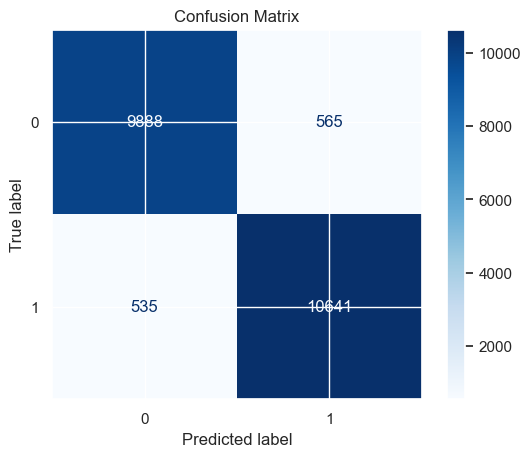

In [ ]:
# Predictions using the linear kernel SVM model
y_pred = svm_model.predict(x_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.959545055249896
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     10453
           1       0.96      0.97      0.96     11176

    accuracy                           0.96     21629
   macro avg       0.96      0.96      0.96     21629
weighted avg       0.96      0.96      0.96     21629

Confusion Matrix:
 [[ 9965   488]
 [  387 10789]]


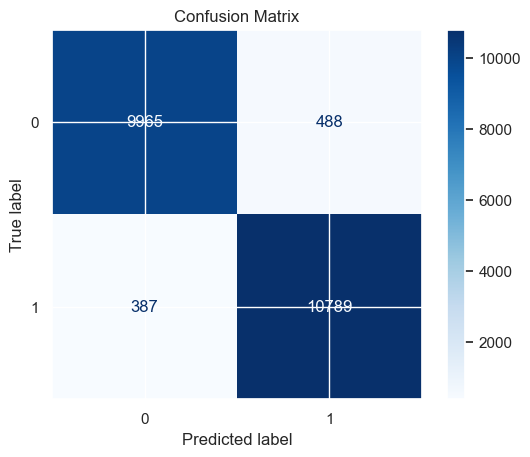

In [251]:
# Predictions using the rbf kernel model and the test data
y_pred = svm_rbf.predict(x_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### STEP 7: Visulaising the results

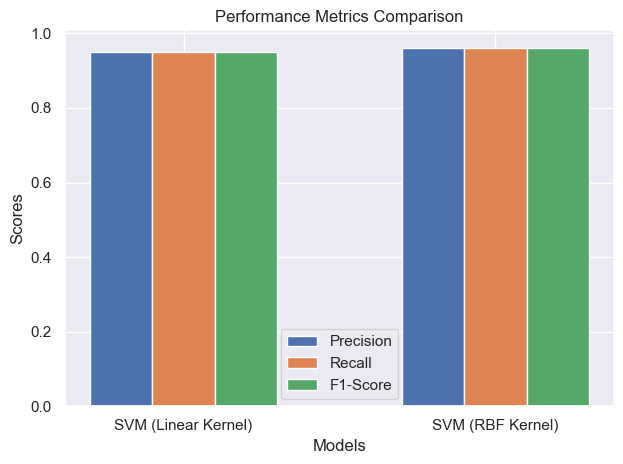

In [256]:
models= ['SVM (Linear Kernel)','SVM (RBF Kernel)']
precision = [0.9491423551712977, 0.959545055249896]
recall = [0.95, 0.96]
f1_scores = [0.95, 0.96]

bar_width = 0.2
x = np.arange(len(models))

fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width, precision, bar_width, label='Precision')
bar2 = ax.bar(x, recall, bar_width, label='Recall')
bar3 = ax.bar(x + bar_width, f1_scores, bar_width, label='F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the graph
plt.tight_layout()
plt.show()

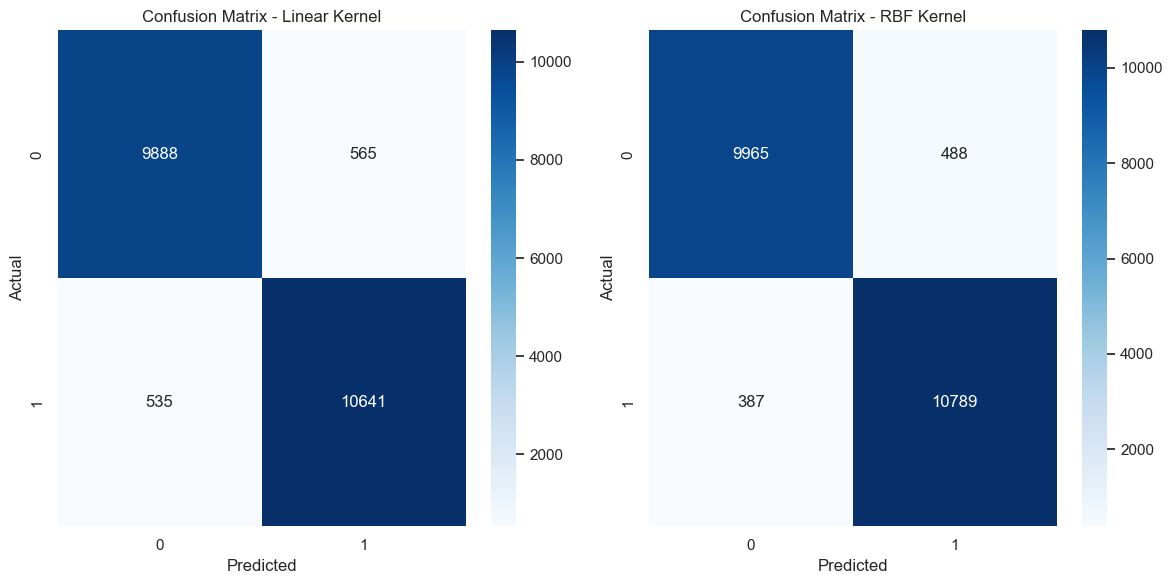

In [257]:
import seaborn as sns

# Confusion matrices
confusion_matrix_linear = [[9888, 565], [535, 10641]]  # Replace with actual values
confusion_matrix_rbf = [[9965, 488], [387, 10789]]  # Replace with actual values

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Linear Kernel Confusion Matrix
sns.heatmap(confusion_matrix_linear, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Linear Kernel')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot RBF Kernel Confusion Matrix
sns.heatmap(confusion_matrix_rbf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - RBF Kernel')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()
